# MTurk Similarity Comparison User Study 1: Results

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [5]:
df = pd.read_csv('~/Downloads/Batch_3580188_batch_results.csv') # Initial test run with 5 repetitions
df = pd.read_csv('~/Downloads/Batch_3580708_batch_results.csv') # 25 repetitions

In [6]:
print('Average worker time was {:.2f} minutes'.format(np.mean(df['WorkTimeInSeconds']) / 60))

Average worker time was 5.51 minutes


In [61]:
pattern_sizes = 3
pattern_sizes_names = ['3 kb', '12 kb', '120 kb']
pattern_sizes_shortnames = ['3kb', '12kb', '120kb']
comparisons = 9
techniques = 7
technique_options = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
technique_names = ['CAE*', 'ED', 'SAX', 'DTW', 'UMAP', 'TSFRESH', 'XCORR']
options = 2
option_names = ['most', 'second most']

## Aggregate results

In [8]:
results_3kb = []
results_12kb = []
results_120kb = []

results = [results_3kb, results_12kb, results_120kb]

rows_3kb = np.where(df['Input.T0A'].str.contains('3KB', regex=False).values)[0]
rows_12kb = np.where(df['Input.T0A'].str.contains('12KB', regex=False).values)[0]
rows_120kb = np.where(df['Input.T0A'].str.contains('120KB', regex=False).values)[0]

for c in np.arange(comparisons):
    c_res_3kb = []
    c_res_12kb = []
    c_res_120kb = []
    for o in np.arange(options):
        o_res_3kb = []
        o_res_12kb = []
        o_res_120kb = []
        for t in technique_options:
            counts = df['Answer.T{}{}{}.{}'.format(str(c), str(o + 1), t, t)].value_counts()
            try:
                o_res_3kb.append(df['Answer.T{}{}{}.{}'.format(str(c), str(o + 1), t, t)][rows_3kb].value_counts().loc[True])
            except KeyError:
                o_res_3kb.append(0)
            try:
                o_res_12kb.append(df['Answer.T{}{}{}.{}'.format(str(c), str(o + 1), t, t)][rows_12kb].value_counts().loc[True])
            except KeyError:
                o_res_12kb.append(0)
            try:
                o_res_120kb.append(df['Answer.T{}{}{}.{}'.format(str(c), str(o + 1), t, t)][rows_120kb].value_counts().loc[True])
            except KeyError:
                o_res_120kb.append(0)
        c_res_3kb.append(o_res_3kb)
        c_res_12kb.append(o_res_12kb)
        c_res_120kb.append(o_res_120kb)
    results_3kb.append(c_res_3kb)
    results_12kb.append(c_res_12kb)
    results_120kb.append(c_res_120kb)

## Results

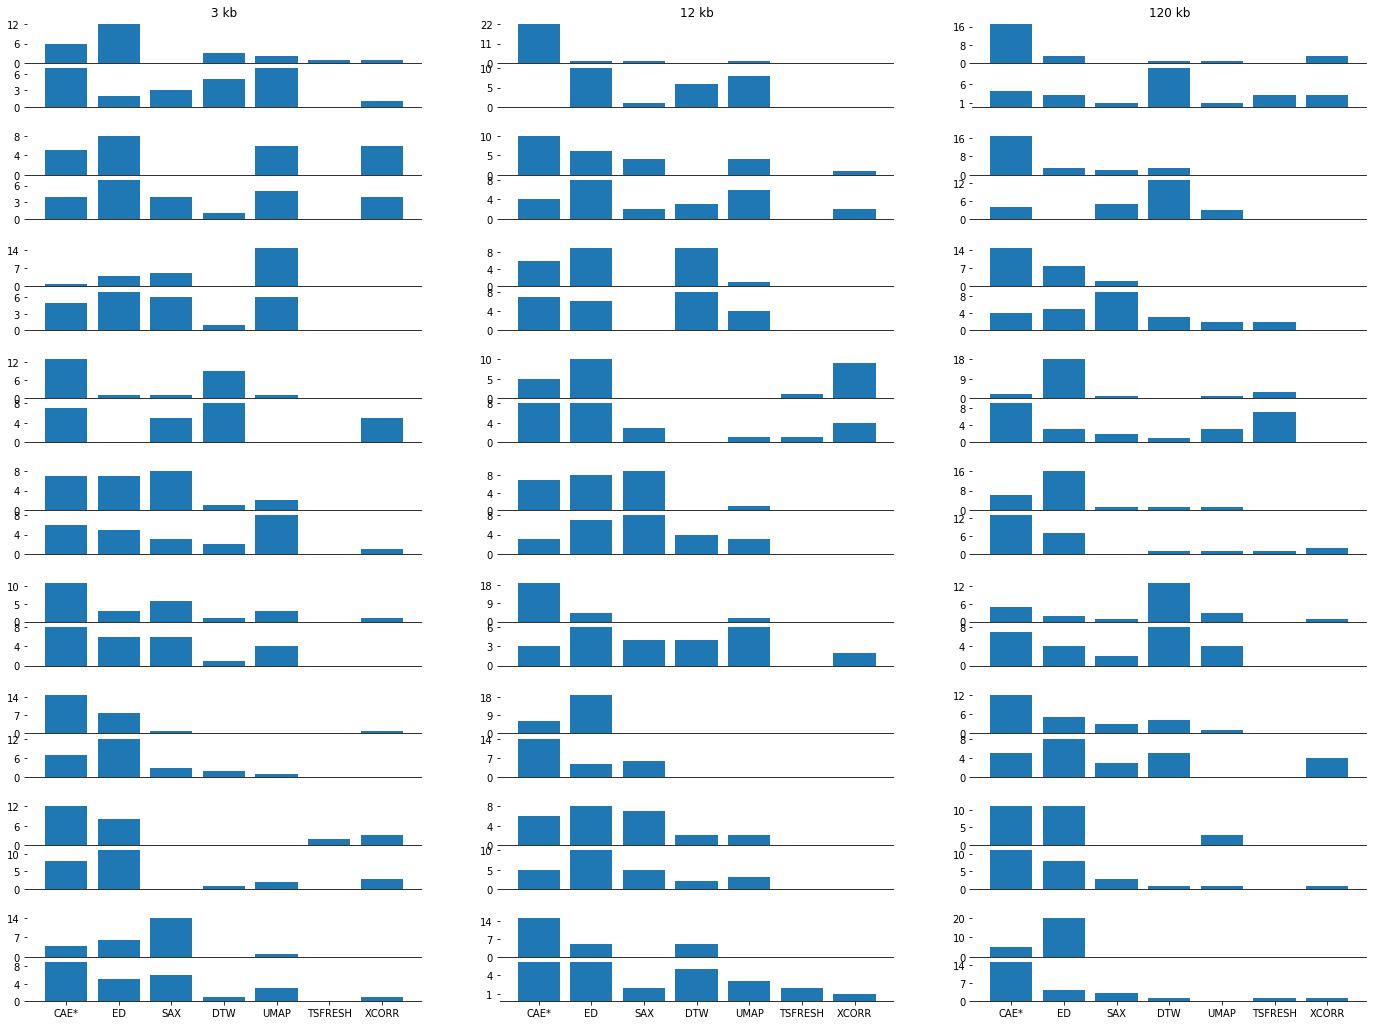

In [62]:
import math

fig, ax = plt.subplots(
    nrows=comparisons * (options + 1) - 1,
    ncols=pattern_sizes,
    figsize=(8 * pattern_sizes, comparisons * options),
    sharex=True,
    gridspec_kw=dict(height_ratios=([1,1,0.5] * (comparisons - 1) + [1,1]), hspace=0.1)
)

for c in range(comparisons):
    for o in range(options):
        for s in range(pattern_sizes):
            res = results[s][c][o]
            ax[c * 3 + o, s].bar(technique_names, res)
            ax[c * 3 + o, s].set_yticks(range(min(res), max(res) + 1, max(1, math.floor(max(res) / 2))))
            if c == 0 and o == 0:
                ax[c * 3 + o, s].set_title(pattern_sizes_names[s])
            if c < (comparisons - 1) or o != 1:
                ax[c * 3 + o, s].tick_params(axis='x', length=0)
            ax[c * 3 + o, s].spines['top'].set_visible(False)
            ax[c * 3 + o, s].spines['left'].set_visible(False)
            ax[c * 3 + o, s].spines['right'].set_visible(False)
        
    if c < comparisons - 1:
        for s in range(pattern_sizes):
            ax[c * 3 + 2, s].set_xticks([], [])
            ax[c * 3 + 2, s].set_yticks([], [])
            ax[c * 3 + 2, s].tick_params(axis='x', length=0)
            ax[c * 3 + 2, s].spines['top'].set_visible(False)
            ax[c * 3 + 2, s].spines['right'].set_visible(False)
            ax[c * 3 + 2, s].spines['bottom'].set_visible(False)
            ax[c * 3 + 2, s].spines['left'].set_visible(False)

## Most and second most combined

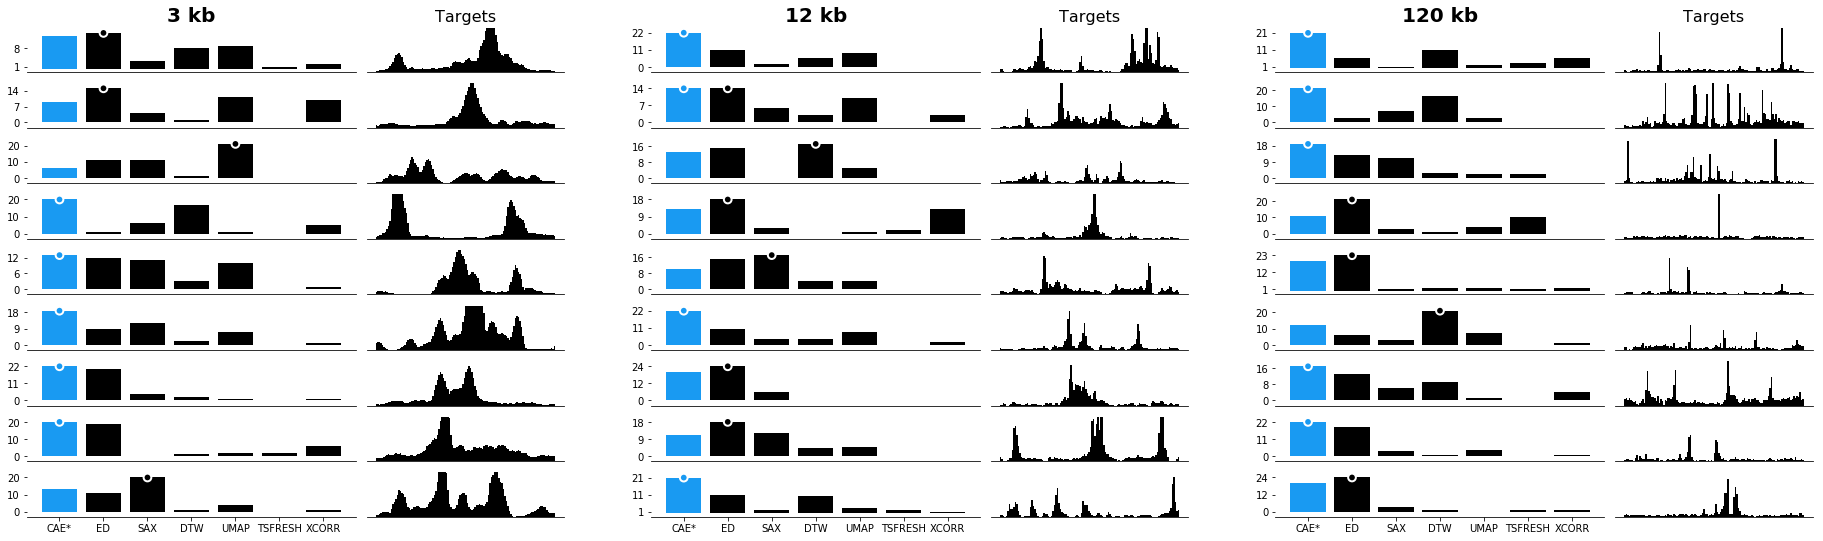

In [63]:
fig, ax = plt.subplots(
    nrows=comparisons,
    ncols=pattern_sizes * 3 - 1,
    figsize=(8 * (pattern_sizes + 1), comparisons),
    gridspec_kw=dict(width_ratios=([1,0.6,0.2] * (pattern_sizes - 1) + [1,0.6]), wspace=0.05, hspace=0.25)
)

with h5py.File('search-targets.h5', 'r') as f:
    for c in range(comparisons):
        for s in range(pattern_sizes):
            res = np.array([x + results[s][c][1][i] for i, x in enumerate(results[s][c][0])])

            colors = np.zeros((7, 4)).astype(np.float)
            colors[0,:] = np.array([25.0, 154.0, 242.0, 0.0]) / 255.0
            colors[np.where(res == np.max(res))[0],3] = 1.0
            edgecolors = np.ones((7, 4))
            edgecolors[:,3] = 0
            edgecolors[np.where(res == np.max(res))[0],3] = 1.0
            
            ax[c, s * 3].bar(technique_names, res, color=['#199AF2', '#000000', '#000000', '#000000', '#000000', '#000000', '#000000'], zorder=1)
            ax[c, s * 3].scatter(technique_names, res, color=colors, edgecolors=edgecolors, linewidths=2, s=60, zorder=2)
            
            ax[c, s * 3].set_yticks(range(min(res), max(res) + 1, max(1, math.floor(max(res) / 2))))
            if c == 0:
                ax[c, s * 3].set_title(pattern_sizes_names[s], fontsize=20, fontweight='bold')
            if c < (comparisons - 1):
                ax[c, s * 3].tick_params(axis='x', length=0)
                ax[c, s * 3].set_xticks([], [])
            ax[c, s * 3].spines['top'].set_visible(False)
            ax[c, s * 3].spines['left'].set_visible(False)
            ax[c, s * 3].spines['right'].set_visible(False)

            target_pattern = f['targets_{}'.format(pattern_sizes_shortnames[s])][c]
            ax[c, s * 3 + 1].bar(np.arange(target_pattern.size), target_pattern, width=1.0, color='k')
            ax[c, s * 3 + 1].set_ylim(0, 1)
            ax[c, s * 3 + 1].set_xticks([], [])
            ax[c, s * 3 + 1].set_yticks([], [])
            ax[c, s * 3 + 1].spines['top'].set_visible(False)
            ax[c, s * 3 + 1].spines['left'].set_visible(False)
            ax[c, s * 3 + 1].spines['right'].set_visible(False)
            if c == 0:
                ax[c, s * 3 + 1].set_title('Targets', fontsize=16)
            
            if s < pattern_sizes - 1:
                ax[c, s * 3 + 2].set_xticks([], [])
                ax[c, s * 3 + 2].set_yticks([], [])
                ax[c, s * 3 + 2].spines['top'].set_visible(False)
                ax[c, s * 3 + 2].spines['right'].set_visible(False)
                ax[c, s * 3 + 2].spines['bottom'].set_visible(False)
                ax[c, s * 3 + 2].spines['left'].set_visible(False)

fig.savefig(
    'user-study-1-results.png',
    bbox_inches="tight",
    pad_inches=0
)

## Chi-Square

In [75]:
for s in range(pattern_sizes):
    res_merged = np.sum(np.sum(np.array(results[s]), axis=1), axis=0)
    chi2_stat, p_val = stats.chisquare(res_merged)
    
    print('Size: {}'.format(pattern_sizes_names[s]))
    print('Chi2 Stat {}'.format(chi2_stat))
    print("P-Value: {}".format(p_val))
    print()

Size: 3 kb
Chi2 Stat 206.4444444444444
P-Value: 8.055437295394612e-42

Size: 12 kb
Chi2 Stat 284.5644444444444
P-Value: 1.6557386673466367e-58

Size: 120 kb
Chi2 Stat 319.0044444444444
P-Value: 6.902620545376983e-66



## Post-hoc pairwise comparisons with Holm-Bonferroni-corrected Fisher exact tests

In [64]:
pairwise_comparisons = [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6]]
pairwise_comparisons_pvalues = []
pairwise_comparisons_pvalues_corrected = []

for s in range(pattern_sizes):
    print('====================')
    print('Size: {}'.format(pattern_sizes_names[s]))
    print('====================')
    print()
    
    pvalues = []
    
    results_merged = np.sum(results[s], axis=1)
    
    for pairwise_comparison in pairwise_comparisons:
        data = np.concatenate(
            (
                np.sum(results_merged[:,pairwise_comparison], axis=0).reshape((1, -1)),
                np.array([[
                    np.floor(np.sum(results_merged[:,pairwise_comparison]) / 2).astype(np.int),
                    np.ceil(np.sum(results_merged[:,pairwise_comparison]) / 2).astype(np.int)
                ]])
            ),
            axis=0
        )

        oddsratio, pvalue = stats.fisher_exact(data)

        pvalues.append(pvalue)

    significance, corrected_pvalues, _, _ = multipletests(pvalues, alpha=0.05, method='holm')
    
    pairwise_comparisons_pvalues.append(pvalues)
    pairwise_comparisons_pvalues_corrected.append(corrected_pvalues)

    for i, pairwise_comparison in enumerate(pairwise_comparisons):
        print('Comparison : {} vs {}'.format(technique_names[pairwise_comparison[0]], technique_names[pairwise_comparison[1]]))
        print('P-value    : {}'.format(pvalues[i]))
        print('Corr. P-val: {}'.format(corrected_pvalues[i]))
        print('Significant? {}'.format(significance[i]))
        print()
    
    print()
    

Size: 3 kb

Comparison : CAE* vs ED
P-value    : 0.32178117350790286
Corr. P-val: 0.32178117350790286
Significant? False

Comparison : CAE* vs SAX
P-value    : 0.0019483958035769848
Corr. P-val: 0.0038967916071539696
Significant? True

Comparison : CAE* vs DTW
P-value    : 2.2910768200020403e-08
Corr. P-val: 9.164307280008161e-08
Significant? True

Comparison : CAE* vs UMAP
P-value    : 0.0005608619652869397
Corr. P-val: 0.0016825858958608192
Significant? True

Comparison : CAE* vs TSFRESH
P-value    : 6.026919842904277e-22
Corr. P-val: 3.616151905742567e-21
Significant? True

Comparison : CAE* vs XCORR
P-value    : 2.207381602327927e-10
Corr. P-val: 1.1036908011639635e-09
Significant? True


Size: 12 kb

Comparison : CAE* vs ED
P-value    : 0.7362157398954523
Corr. P-val: 0.7362157398954523
Significant? False

Comparison : CAE* vs SAX
P-value    : 1.6938853864885319e-06
Corr. P-val: 3.3877707729770638e-06
Significant? True

Comparison : CAE* vs DTW
P-value    : 3.9412794995340284e-07
